In [1]:
# Problem
# Özellikleri belirtildiğinde kişilerin diyabet hastası olup olmadıklarını tahmin edebilecek bir makine öğrenmesi
# modeli geliştirilmesi istenmektedir.


# Veri seti ABD'deki Ulusal Diyabet-Sindirim-Böbrek Hastalıkları Enstitüleri'nde tutulan büyük veri setinin parçasıdır.
# ABD'deki Arizona Eyaleti'nin en büyük 5. şehri olan Phoenix şehrinde yaşayan 21 yaş ve üzerinde olan Pima Indian kadınları
# üzerinde yapılan diyabet araştırması için kullanılan verilerdir. 768 gözlem ve 8 sayısal bağımsız değişkenden oluşmaktadır.
# Hedef değişken "outcome" olarak belirtilmiş olup; 1 diyabet test sonucunun pozitif oluşunu,
# 0 ise negatif oluşunu belirtmektedir.

# Pregnancies: Hamilelik sayısı
# Glucose: Glikoz
# BloodPressure: Kan basıncı (Diastolic(Küçük Tansiyon))
# SkinThickness: Cilt Kalınlığı
# Insulin: İnsülin.
# BMI: Beden kitle indeksi.
# DiabetesPedigreeFunction: Soyumuzdaki kişilere göre diyabet olma ihtimalimizi hesaplayan bir fonksiyon.
# Age: Yaş (yıl)
# Outcome: Kişinin diyabet olup olmadığı bilgisi. Hastalığa sahip (1) ya da değil (0)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, cross_validate

pd.set_option("display.max_columns",None)
pd.set_option("display.float_format",lambda x: '%.3f' % x)
pd.set_option("display.width",500)

In [2]:
# quantile bir veri kümesinin belirli yüzdelik dilimlerine karşılık gelen değerleri hesaplamak için kullanılır.
def outlier_tresholds(df,col_name,q1=.05,q3=.95):
    quartile1 = df[col_name].quantile(q1) 
    quartile3 = df[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit , up_limit

# Belirli bir sütunun aykırı değerler içerip içermediğini kontrol etmek için kullanılır.
def check_outlier(df,col_name):
    low_limit, up_limit = outlier_tresholds(df,col_name)
    if df[(df[col_name] > up_limit) | (df[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False
    
# Veri çerçevesindeki belirli bir değişken için aykırı değerleri alt ve üst sınırlarla değiştirmek için kullanılır.    
def replace_with_thresholds(df,variable,q1=.05,q3=.95):
    low_limit, up_limit = outlier_tresholds(df,variable,q1=.05,q3=.95)
    df.loc[(df[variable]<low_limit),variable] = low_limit
    df.loc[(df[variable]>up_limit),variable] = up_limit  

In [8]:
######################################################
# 1 - KEŞİFCİ VERİ ANALİZİ (Exploratory Data Analysis)
######################################################

In [3]:
df = pd.read_csv("diabetes.csv")

In [4]:
# Target Analizi
################

# Kaç tane var
df["Outcome"].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

In [5]:
# Değer oranları
100 * df["Outcome"].value_counts() / len(df)

0   65.104
1   34.896
Name: Outcome, dtype: float64

In [6]:
# Feature'ların(Bağımsız Değişkenler) Analizi
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.000,3.845,3.370,0.000,1.000,3.000,6.000,17.000
Glucose,768.000,120.895,31.973,0.000,99.000,117.000,140.250,199.000
BloodPressure,768.000,69.105,19.356,0.000,62.000,72.000,80.000,122.000
SkinThickness,768.000,20.536,15.952,0.000,0.000,23.000,32.000,99.000
Insulin,768.000,79.799,115.244,0.000,0.000,30.500,127.250,846.000
BMI,768.000,31.993,7.884,0.000,27.300,32.000,36.600,67.100
DiabetesPedigreeFunction,768.000,0.472,0.331,0.078,0.244,0.372,0.626,2.420
Age,768.000,33.241,11.760,21.000,24.000,29.000,41.000,81.000
Outcome,768.000,0.349,0.477,0.000,0.000,0.000,1.000,1.000


In [7]:
# Target vs Features

# Diyabet olanların hamilelik ortalaması
df.groupby("Outcome").agg({"Pregnancies":"mean"})

,Pregnancies
Outcome,
0,3.298
1,4.866


In [8]:
# Fonksiyon yazıp tüm değişkenlere göre ortalama baktık
def target_summary_with_num(df,target,num_col):
    print(df.groupby(target).agg({num_col:"mean"}),end="\n\n\n")
    
for col in df.columns:
    target_summary_with_num(df,"Outcome",col)

         Pregnancies
Outcome             
0              3.298
1              4.866


         Glucose
Outcome         
0        109.980
1        141.257


         BloodPressure
Outcome               
0               68.184
1               70.825


         SkinThickness
Outcome               
0               19.664
1               22.164


         Insulin
Outcome         
0         68.792
1        100.336


           BMI
Outcome       
0       30.304
1       35.143


         DiabetesPedigreeFunction
Outcome                          
0                           0.430
1                           0.550


           Age
Outcome       
0       31.190
1       37.067


         Outcome
Outcome         
0          0.000
1          1.000




In [22]:
#####################################
# Veri Ön İşleme (Data Preprocessing)
#####################################

In [9]:
# Boş değerler
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [10]:
# Aykırı değerler
for col in df.columns:
    print(col, check_outlier(df,col))    

Pregnancies False
Glucose False
BloodPressure False
SkinThickness False
Insulin True
BMI False
DiabetesPedigreeFunction False
Age False
Outcome False


In [11]:
# Sadece İnsülin değerlerinde aykırılık var onları değiştiriyoruz.
replace_with_thresholds(df,"Insulin")

for col in df.columns:
    print(col, check_outlier(df,col)) # Çözüldü

Pregnancies False
Glucose False
BloodPressure False
SkinThickness False
Insulin False
BMI False
DiabetesPedigreeFunction False
Age False
Outcome False


In [12]:
# Değişkenleri ölçeklemek (Scale etmek) -> Standartlaştırma
for col in df.columns:
    df[col] = RobustScaler().fit_transform(df[[col]]) 
# Bütün gözlem birim değerlerinden medyanı çıkarıp range değerine bölüyor.
# Standart Scaleden farkı; Aykırı değerlerden etkilenmiyor.
    
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.600,0.752,0.000,0.375,-0.240,0.172,0.665,1.235,1.000
1,-0.400,-0.776,-0.333,0.188,-0.240,-0.581,-0.056,0.118,0.000
2,1.000,1.600,-0.444,-0.719,-0.240,-0.935,0.783,0.176,1.000
3,-0.400,-0.679,-0.333,0.000,0.499,-0.419,-0.537,-0.471,0.000
4,-0.600,0.485,-1.778,0.375,1.081,1.194,5.008,0.235,1.000


In [42]:
#############################
# Model & Tahmin (Prediction)
#############################

In [13]:
y = df["Outcome"] # Bağımlı
X = df.drop("Outcome",axis=1) # Bağımsız

In [14]:
# Model kuruldu
log_model = LogisticRegression().fit(X,y) 

# Fit yöntemi veri seti üzerinde lojistik regresyon modelini eğitir ve modelin X'e bağlı olarak y'yi tahmin etmesini sağlar.

# Lojistik regresyon, sınıflandırma problemlerinde kullanılan bir makine öğrenmesi algoritmasıdır.
# Genellikle, bağımlı değişkenin (y) iki kategoriden birine ait olup olmadığını tahmin etmek için kullanılır.

In [15]:
# Sabit
log_model.intercept_

array([-1.23439588])

In [16]:
# Kat sayılar
log_model.coef_

array([[ 0.59906785,  1.41770936, -0.23152362,  0.01973855, -0.14571255,
         0.81741997,  0.35522795,  0.25655154]])

In [17]:
y_pred = log_model.predict(X) 

# Veri setindeki özellikleri (X) kullanarak bağımlı değişkeni (y) tahmin etmek için kullanılır.
# Predict yöntemi, modeli veri seti üzerinde kullanarak bağımlı değişkenin tahmin edilen değerlerini döndürür.

In [18]:
# Tahmin edilen ilk on değer
y_pred[0:10]

array([1., 0., 1., 0., 1., 0., 0., 1., 1., 0.])

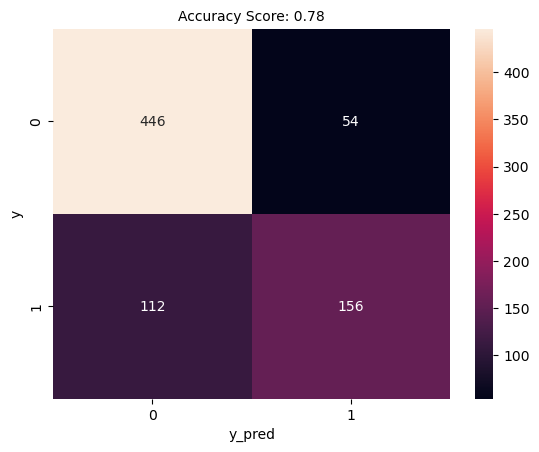

In [19]:
############################
# Model Başarı Değerlendirme
############################
def plot_confusion_matrix(y,y_pred):
    acc = round(accuracy_score(y,y_pred),2)
    cm = confusion_matrix(y,y_pred)
    sns.heatmap(cm,annot=True,fmt=".0f")
    plt.xlabel("y_pred")
    plt.ylabel("y")
    plt.title("Accuracy Score: {0}".format(acc), size=10)
    plt.show

# Bir sınıflandırma modelinin tahminlerinin gerçek değerlerle karşılaştırılması için
# bir karmaşıklık matrisi (confusion matrix) çizmek için kullanılır.

plot_confusion_matrix(y,y_pred)

In [20]:
print(classification_report(y,y_pred))

# Sınıflandırma modelinin performansını daha ayrıntılı bir şekilde değerlendirmek için kullanılır.
# Bu rapor, modelin her bir sınıf için 
# hassasiyet (precision),
# özgüllük (recall),
# F1-score 
# destek (support) değerlerini gösterir.

# accuracy: 0.78
# precision: 0.74
# recall: 0.58
# f1-score: 0.65

              precision    recall  f1-score   support

         0.0       0.80      0.89      0.84       500
         1.0       0.74      0.58      0.65       268

    accuracy                           0.78       768
   macro avg       0.77      0.74      0.75       768
weighted avg       0.78      0.78      0.78       768



In [21]:
# ROC AUC
y_prob = log_model.predict_proba(X)[:,1]
roc_auc_score(y,y_prob)
# 0.83

# Farklı classification treshold değerlerine göre oluşabilecek başarılarımıza yönelik genel bir metrik.
# Lojistik regresyon modelinin ROC AUC skorunu hesaplar ve modelin sınıflandırma performansını değerlendirmek için kullanır.
# ROC AUC skoru, sınıflandırma modelinin farklı eşik değerleri altında nasıl performans gösterdiğini gösterir.

0.8393955223880598

In [23]:
######################################
# Model Doğrulama(Validation): Holdout
######################################

# Holdout model setini ikiye böl birisi ile modeli eğit birisi ile test et.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=17)

In [29]:
log_model = LogisticRegression().fit(X_train, y_train) # Modeli eğitiyoruz

y_pred = log_model.predict(X_test) # Tahmin edilen değerler

y_prob = log_model.predict_proba(X_test)[:, 1] # Ait olma olasılık değerleri

In [30]:
print(classification_report(y_test,y_pred))

# Yeni değerler;
# accuracy: 0.77
# precision: 0.79
# recall: 0.53
# f1-score: 0.63

# Önceki değerler; 
# accuracy: 0.78
# precision: 0.74
# recall: 0.58
# f1-score: 0.65

              precision    recall  f1-score   support

         0.0       0.77      0.92      0.84        97
         1.0       0.79      0.53      0.63        57

    accuracy                           0.77       154
   macro avg       0.78      0.72      0.73       154
weighted avg       0.78      0.77      0.76       154



In [32]:
# AUC
roc_auc_score(y_test,y_prob)

0.8755652016639537

In [34]:
######################################################
# 10 Katlı Çarpaz Doğrulama (10-Fold Cross Validation)
######################################################

# Modelin doğrulama sürecini en doğru şekilde ele alma.
# Veri ilk olarak 10 parçaya ayrılır, 9 parçası ile model kurulur, 1 parçası ile model test edilir.
# Model bu 10 parçada da olacak şekilde devam eder ve sonunda bütün test hatalarının ortlaması alınır.
# Model böylece model veri setinin farklı parçaları ile modellenip, farklı parçaları ile test edilir,
# bundan dolayı bazı senaryoları da barındırır.

y = df["Outcome"] # Bağımlı
X = df.drop("Outcome",axis=1) # Bağımsız

log_model = LogisticRegression().fit(X, y) # Model kuruldu

In [35]:
cv_result = cross_validate(log_model, X, y, cv=5, scoring=["accuracy","precision","recall","f1","roc_auc"])

# 5 katlı bir cross validation
# Başarı metriklerini getirir.

In [43]:
# Ortalama Accuracy
cv_result["test_accuracy"].mean()
# 0.7721925133689839
 
cv_result["test_precision"].mean()
# 0.7192472060223519

cv_result["test_recall"].mean()
# 0.5747030048916841

cv_result["test_f1"].mean()
# 0.6371421090986309

cv_result["test_roc_auc"].mean()
# 0.8327295597484277

# Önceki işlemlerden değerler
# accuracy: 0.77
# precision: 0.79
# recall: 0.53
# f1-score: 0.63

# accuracy: 0.78
# precision: 0.74
# recall: 0.58
# f1-score: 0.65

0.8327295597484277

In [45]:
# Rastgele bir veri aldık
random_user = X.sample(1,random_state=45)

log_model.predict(random_user)
# Bu kişi diyabettir diye bir şey dedi
# array([1.])

array([1.])